### Generating Native-Guides for The FCN Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
from scipy.spatial.distance import cdist, pdist
from scipy import stats
from sklearn.neighbors import DistanceMetric
from tslearn.datasets import UCR_UEA_datasets
#
from sklearn.neighbors import NearestNeighbors
from tslearn.neighbors import KNeighborsTimeSeries
#
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, GlobalAveragePooling1D, BatchNormalization, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import function
from sklearn.neighbors import LocalOutlierFactor
from tslearn.utils import to_sklearn_dataset
from tensorflow import keras
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
print(tf.__version__)


2.5.0


In [2]:
dataset = 'ecg200'

In [3]:
def ucr_data_loader(dataset):
    
    X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(dataset)
    
    return X_train, y_train, X_test, y_test

In [4]:
def label_encoder(training_labels, testing_labels):
    le = preprocessing.LabelEncoder()
    le.fit(np.concatenate((training_labels, testing_labels), axis=0))
    y_train = le.transform(training_labels)
    y_test = le.transform(testing_labels)    
    return y_train, y_test
    
    

In [5]:
def native_guide_retrieval(query, predicted_label, distance, n_neighbors):

    df = pd.DataFrame(y_train, columns = ['label'])
    df.index.name = 'index'
    df[df['label'] == 1].index.values, df[df['label'] != 1].index.values
    
    ts_length = X_train.shape[1]
    

    knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric = distance)
    
    knn.fit(X_train[list(df[df['label'] != predicted_label].index.values)])
    
    dist,ind = knn.kneighbors(query.reshape(1,ts_length), return_distance=True)
    return dist[0], df[df['label'] != predicted_label].index[ind[0][:]]

### Native Guide CFS

In [6]:
dataset = 'Lightning2'


# model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model.hdf5')
model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model_myrun.hdf5')


X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
y_train, y_test = label_encoder(y_train, y_test)


y_pred = np.argmax(model.predict(X_test), axis=1)

nuns = []
for instance in range(len(X_test)):
    nuns.append(native_guide_retrieval(X_test[instance], y_pred[instance], 'euclidean', 1)[1][0])
nuns = np.array(nuns)

In [14]:
def findSubarray(a, k): #used to find the maximum contigious subarray of length k in the explanation weight vector
    
    n = len(a)
    
    vec=[] 

    # Iterate to find all the sub-arrays 
    for i in range(n-k+1): 
        temp=[] 

        # Store the sub-array elements in the array 
        for j in range(i,i+k): 
            temp.append(a[j]) 

        # Push the vector in the container 
        vec.append(temp) 

    sum_arr = []
    for v in vec:
        sum_arr.append(np.sum(v))

    return (vec[np.argmax(sum_arr)])

In [8]:
# training_weights = np.load('../Class_Activation_Mapping/' +str(dataset) +'_cam_train_weights.npy')
# testing_weights = np.load('../Class_Activation_Mapping/' +str(dataset) +'_cam_test_weights.npy')
training_weights = np.load('../Class_Activation_Mapping/' +str(dataset) +'_cam_train_weights_myrun.npy')
testing_weights  = np.load('../Class_Activation_Mapping/' +str(dataset) +'_cam_test_weights_myrun.npy')

In [12]:
def counterfactual_generator_swap(instance, nun, subarray_length):
    # 1) 在 NUN 的 CAM 上找长度为 k 的“最重要连续段”
    most_influencial_array=findSubarray((training_weights[nun]), subarray_length)
    # 2) 在 CAM 中找到该段的起始位置（以段的第一个值匹配推回去）
    starting_point = np.where(training_weights[nun]==most_influencial_array[0])[0][0]
     # 3) 把“这段”从 NUN 复制到测试样本同位置（硬替换）
    X_example = np.concatenate((X_test[instance][:starting_point], (X_train[nun][starting_point:subarray_length+starting_point]), X_test[instance][subarray_length+starting_point:]))
    # 4) 看替换后的样本对“原预测类”的概率（softmax）
    prob_target = model.predict(X_example.reshape(1,-1,1))[0][y_pred[instance]]
    # 5) 如果还没翻类（原类概率 > 0.5），就把窗口加长，重复 1)~4)
    while prob_target > 0.5:
        
        subarray_length +=1
        
        most_influencial_array=findSubarray((training_weights[nun]), subarray_length)
        starting_point = np.where(training_weights[nun]==most_influencial_array[0])[0][0]
        X_example = np.concatenate((X_test[instance][:starting_point], (X_train[nun][starting_point:subarray_length+starting_point]), X_test[instance][subarray_length+starting_point:]))
        prob_target = model.predict(X_example.reshape(1,-1,1))[0][y_pred[instance]]
        
    return X_example

In [10]:
test_instances = np.array(range(len(X_test)))
test_instances

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [11]:
#单数据集测试
cf_cam_swap = []

for test_instance, nun in zip(test_instances, nuns):
    # 第三个参数 1 是最小窗口长度 k（与原 notebook 一致）
    cf_cam_swap.append(counterfactual_generator_swap(test_instance, nun, 1))

# 保存为你的 myrun 版本
np.save(str(dataset) + '_native_guide_isw_myrun.npy', np.array(cf_cam_swap))

### For All Datasets

In [12]:
for dataset in ['chinatown', 'gunpoint', 'coffee', 'CBF']:

    # model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model.hdf5')
    # training_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_train_weights.npy')
    # testing_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_test_weights.npy')

    model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model_myrun.hdf5')
    training_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_train_weights_myrun.npy')
    testing_weights  = np.load('../fcn_weights/' +str(dataset) +'_cam_test_weights_myrun.npy')

    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)


    y_pred = np.argmax(model.predict(X_test), axis=1)

    nuns = []
    for instance in range(len(X_test)):
        nuns.append(native_guide_retrieval(X_test[instance], y_pred[instance], 'euclidean', 1)[1][0])
    
    nuns = np.array(nuns)
    test_instances = np.array(range(len(X_test)))
    
    
    cf_cam_swap = []
    
    for test_instance, nun in zip(test_instances, nuns):
        cf_cam_swap.append(counterfactual_generator_swap(test_instance,nun,1))

    #np.save(str(dataset)+'_native_guide_isw.npy', np.array(cf_cam_swap))
    np.save(str(dataset)+'_native_guide_isw_myrun.npy', np.array(cf_cam_swap))


### Looking at Produced Counterfactuals and Diversity

For diverse solutions we can use different NUNs (e.g the 3rd NUN) to guide the counterfactual generation process.

#### CBF

In [18]:
for dataset in ['CBF']:
    
    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    cam_swap_cf = np.load(str(dataset)+'_native_guide_isw_myrun.npy')
    model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model_myrun.hdf5')
    training_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_train_weights_myrun.npy')
    testing_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_test_weights_myrun.npy')
    y_pred = np.argmax(model.predict(X_test), axis=1)    

In [19]:
native_guide_retrieval(X_test[0], y_pred[0], 'euclidean',10)

(array([ 9.82496518, 11.51063329, 11.64218176, 11.88514247, 11.98183798,
        11.9877963 , 12.31450316, 12.32006369, 12.40384597, 12.70900847]),
 Int64Index([2, 24, 15, 0, 27, 9, 28, 25, 1, 29], dtype='int64', name='index'))

In [20]:
np.argmax(model.predict(counterfactual_generator_swap(0, 2,1).reshape(1,-1,1)))
np.argmax(model.predict(counterfactual_generator_swap(0, 9,1).reshape(1,-1,1)))

0

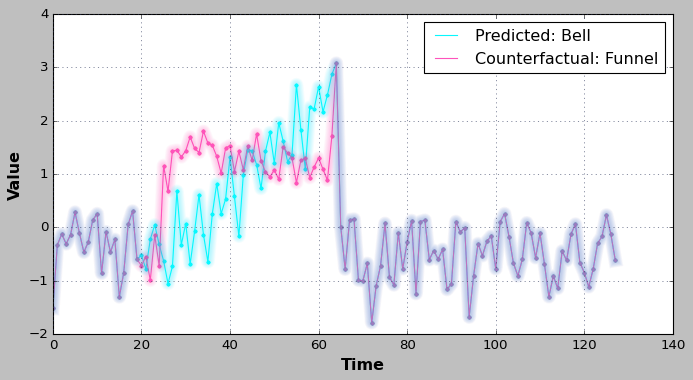

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic")
colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]
df = pd.DataFrame({'Predicted: Bell': list(X_test[0].flatten()),
                   'Counterfactual: Funnel': list(cam_swap_cf[0].flatten())})
fig, ax = plt.subplots(figsize=(10,5))
df.plot(marker='.', color=colors, ax=ax)
# Redraw the data with low alpha and slighty increased linewidth:
n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df.plot(marker='.',
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)

ax.grid(color='#2A3459')
plt.xlabel('Time', fontweight = 'bold', fontsize='large')
plt.ylabel('Value', fontweight = 'bold', fontsize='large')
#plt.savefig('../Images/Initial_Example_Neon.pdf')
plt.show()

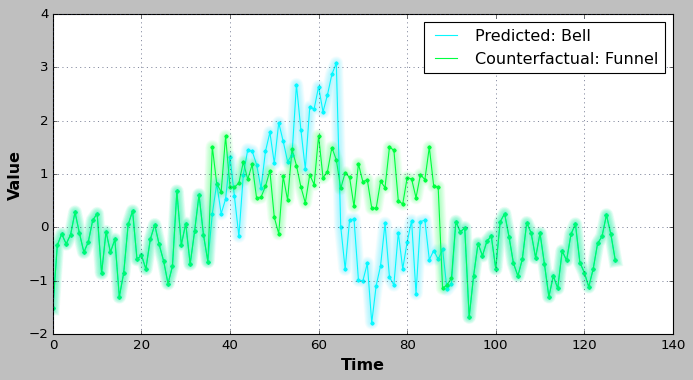

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic")
colors = [
    '#08F7FE',  # teal/cyan
#    '#FE53BB',  # pink
#    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]
df = pd.DataFrame({'Predicted: Bell': list(X_test[0].flatten()),
                   'Counterfactual: Funnel': list(counterfactual_generator_swap(0, 9,1).flatten())})
fig, ax = plt.subplots(figsize=(10,5))
df.plot(marker='.', color=colors, ax=ax)
# Redraw the data with low alpha and slighty increased linewidth:
n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df.plot(marker='.',
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)
    
ax.grid(color='#2A3459')
plt.xlabel('Time', fontweight = 'bold', fontsize='large')
plt.ylabel('Value', fontweight = 'bold', fontsize='large')
#plt.savefig('../Images/Initial_Example_Neon.pdf')
plt.show()

#### Coffee

In [27]:
for dataset in ['coffee']:
    
    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    cam_swap_cf = np.load(str(dataset)+'_native_guide_isw_myrun.npy')
    model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model_myrun.hdf5')
    training_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_train_weights_myrun.npy')
    testing_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_test_weights_myrun.npy')
    y_pred = np.argmax(model.predict(X_test), axis=1)   

In [28]:
np.where(y_pred==0)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int64),)

In [29]:
native_guide_retrieval(X_test[10], y_pred[0], 'euclidean',14)

(array([1.81011016, 1.84947036, 1.96159482, 1.96635242, 1.97374239,
        1.97886154, 2.13515831, 2.14519135, 2.1594211 , 2.17134443,
        2.32487309, 2.50543722, 2.6169788 , 3.16354579]),
 Int64Index([16, 25, 23, 27, 14, 26, 19, 18, 15, 17, 21, 24, 22, 20], dtype='int64', name='index'))

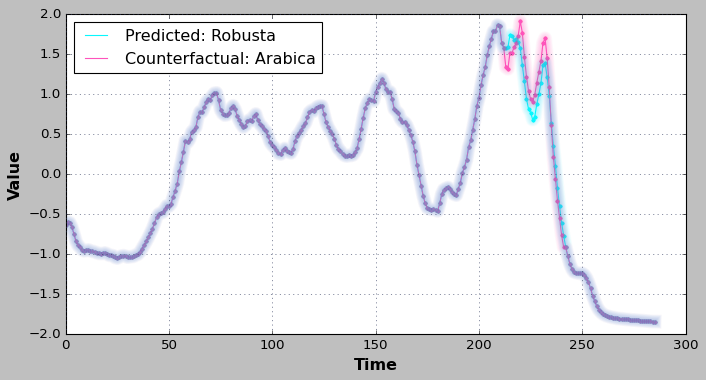

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic")
colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]
df = pd.DataFrame({'Predicted: Robusta': list(X_test[10].flatten()),
                   'Counterfactual: Arabica': list(cam_swap_cf[10].flatten())})
fig, ax = plt.subplots(figsize=(10,5))
df.plot(marker='.', color=colors, ax=ax)
# Redraw the data with low alpha and slighty increased linewidth:
n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df.plot(marker='.',
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)
    
ax.grid(color='#2A3459')
plt.xlabel('Time', fontweight = 'bold', fontsize='large')
plt.ylabel('Value', fontweight = 'bold', fontsize='large')
# plt.savefig('../Images/Coffee_Example.pdf')
plt.show()

#### ECG200 (Diversity)

In [6]:
for dataset in ['ecg200']:
    
    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    cam_swap_cf = np.load(str(dataset)+'_native_guide_isw.npy')
    model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model.hdf5')
    training_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_train_weights.npy')
    testing_weights = np.load('../fcn_weights/' +str(dataset) +'_cam_test_weights.npy')
    y_pred = np.argmax(model.predict(X_test), axis=1)    

In [7]:
np.where(y_pred==0)

(array([ 2,  6,  9, 10, 12, 13, 14, 18, 20, 26, 28, 32, 33, 35, 38, 39, 41,
        42, 51, 52, 53, 57, 59, 60, 63, 64, 65, 75, 84, 86, 87, 91, 92, 97,
        98], dtype=int64),)

In [8]:
native_guide_retrieval(X_test[65], y_pred[65], 'euclidean',10)

(array([4.59697954, 5.36185596, 5.53132266, 5.71314263, 6.1420083 ,
        6.27087678, 6.36499079, 6.79639667, 7.51418388, 8.24182907]),
 Int64Index([95, 62, 41, 40, 79, 70, 11, 38, 10, 94], dtype='int64', name='index'))

In [9]:
y_pred[75]

0

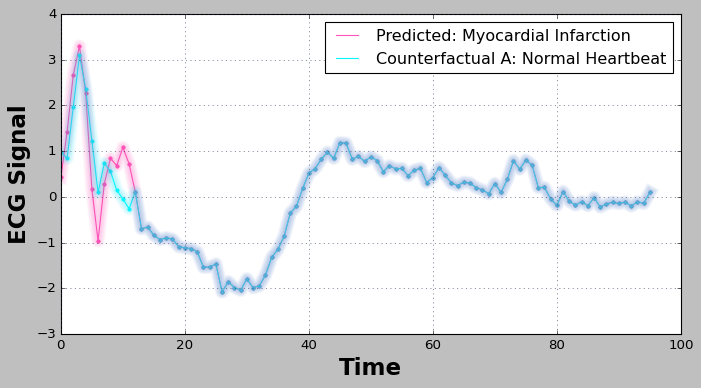

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic")
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0'  # very light grey
#for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
#    plt.rcParams[param] = '#212946'  # bluish dark grey
colors = [    '#FE53BB',  # pink
    '#08F7FE',  # teal/cyan
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]
df = pd.DataFrame({'Predicted: Myocardial Infarction': list(X_test[0].flatten()),
                   'Counterfactual A: Normal Heartbeat': list(cam_swap_cf[0].flatten())})
fig, ax = plt.subplots(figsize=(10,5))
df.plot(marker='.', color=colors, ax=ax)
# Redraw the data with low alpha and slighty increased linewidth:
n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df.plot(marker='.',
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)

ax.grid(color='#2A3459')
plt.xlabel('Time', fontweight = 'bold', fontsize='xx-large')
plt.ylabel('ECG Signal', fontweight = 'bold', fontsize='xx-large')
# plt.savefig('../Images/Diverse_1.pdf')
plt.show()

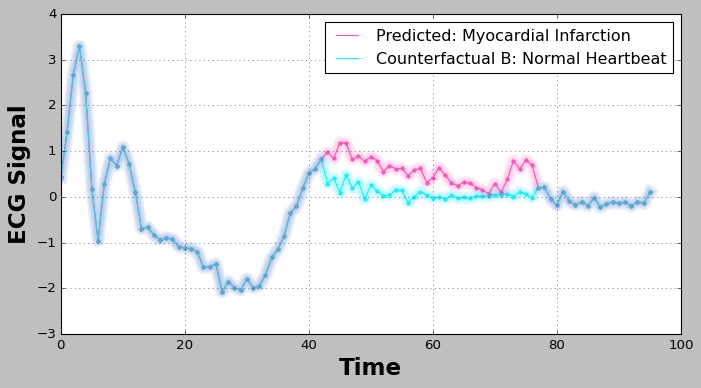

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic")
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0'  # very light grey

colors = [
    '#FE53BB',  # pink
    '#08F7FE',  # teal/cyan
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]
df = pd.DataFrame({'Predicted: Myocardial Infarction': list(X_test[0].flatten()),
                   'Counterfactual B: Normal Heartbeat': list(counterfactual_generator_swap(0, 61,1).flatten())})
fig, ax = plt.subplots(figsize=(10,5))
df.plot(marker='.', color=colors, ax=ax)
# Redraw the data with low alpha and slighty increased linewidth:
n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df.plot(marker='.',
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)

ax.grid(color='#2A3459')
plt.xlabel('Time', fontweight = 'bold', fontsize='xx-large')
plt.ylabel('ECG Signal', fontweight = 'bold', fontsize='xx-large')
# plt.savefig('../Images/Diverse_2.pdf')
plt.show()

In [44]:
model.predict(X_test[1].reshape(1,-1,1))

array([[2.7233877e-08, 1.0000000e+00]], dtype=float32)

In [45]:
model.predict(cam_swap_cf[1].reshape(1,-1,1))

array([[0.6164189 , 0.38358113]], dtype=float32)